In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

## 1. Simple EDA and Baseline Model

In [192]:
# Load the cleaned complete data
all_df = pd.read_pickle('../dump/movie_data_general_all')

In [193]:
# all_df.head()

In [194]:
# convert unit of 'opening_weekend_usa' to million dollors
all_df['opening_weekend_usa'] = all_df['opening_weekend_usa']/1e6
# all_df['budget'] = all_df['budget']/1e6

In [195]:
all_df.describe()

,rating,vote,metascore,budget,opening_weekend_usa,gross_usa,gross_world,runtime
count,19524.000000,1.952400e+04,9002.000000,1.279700e+04,13549.000000,1.426400e+04,1.595800e+04,19457.000000
mean,6.687011,2.566210e+05,75.674961,5.554608e+07,24.647625,1.001224e+08,2.205146e+08,115.931696
std,1.255940,4.640163e+05,9.603985,6.728404e+07,47.973897,1.485524e+08,4.071611e+08,26.124780
min,1.300000,5.000000e+00,61.000000,0.000000e+00,0.000063,3.090000e+02,2.700000e+01,34.000000
25%,5.900000,9.858500e+03,67.000000,9.000000e+06,0.727327,1.016085e+07,8.722585e+06,97.000000
50%,6.800000,4.438500e+04,74.000000,2.700000e+07,8.800230,3.834724e+07,5.153742e+07,110.000000
75%,7.600000,2.332440e+05,83.000000,8.000000e+07,26.887467,1.249938e+08,2.592405e+08,130.000000
max,9.900000,2.337643e+06,100.000000,8.000000e+08,357.115007,9.366622e+08,2.797801e+09,350.000000


In [196]:
# all_df.country

In [197]:
all_df['release_year'] = all_df['release_date'].dt.year

In [581]:
all_df.rename(columns={'certificate':'MPAA'},inplace=True)
all_df.drop_duplicates(subset=['movie_title','release_year'],inplace=True)

In [9]:
# Find top 100 actors
all_df_actor = all_df['star'].str.join(sep='*').str.get_dummies(sep='*')
actor_list = (all_df_actor.sum()).sort_values(ascending=False).index.tolist()[:100]
# actor_list

In [584]:
# Remove outliers
all_df = all_df[all_df.opening_weekend_usa < 100]
all_df = all_df[all_df.movie_title != "Kiki's Delivery Service"]
# all_df = all_df[all_df.movie_title.isin(res_movie)]
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6347 entries, 3 to 5098
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          6347 non-null   object        
 1   rating               6347 non-null   float64       
 2   vote                 6347 non-null   float64       
 3   MPAA                 6347 non-null   object        
 4   genre                6347 non-null   object        
 5   release_date         6347 non-null   datetime64[ns]
 6   metascore            2087 non-null   float64       
 7   keywords             6347 non-null   object        
 8   budget               5125 non-null   float64       
 9   opening_weekend_usa  6347 non-null   float64       
 10  gross_usa            6346 non-null   float64       
 11  gross_world          6339 non-null   float64       
 12  runtime              6331 non-null   float64       
 13  distributor          6339 non-nul

In [904]:
all_df = all_df[all_df.movie_title.isin(res_movie) == False]

In [593]:
con_feature = ['budget','runtime','release_year']
cat_feature = ['MPAA','genre','distributor','language','country','keywords']
target_candidate = ['opening_weekend_usa','gross_usa','gross_world','rating','vote']
# con_feature = ['budget','runtime','film_count_d','avg_rating_d','avg_gross_d','T_movie_age']
# con_book_feature = ['T_book_age','publish_year','page','log_book_popularity','log_author_popularity']
# target_candidate = ['opening_weekend_usa','log_owu','gross_usa','gross_world','rating']

# potential_feature = ['rating_value_b','rating_count_b','review_count_b']

In [594]:
# Choose only the continuous variables for now

# cc_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature + cat_feature].copy()
c_movie_df = all_df[['opening_weekend_usa'] + con_feature].copy() # only continuous features for movie
# c_all_df = all_df[['opening_weekend_usa'] + con_feature + con_book_feature].copy() # continuous features both movie and book

In [155]:
# c_df.describe()

In [907]:
# cc_df.info()

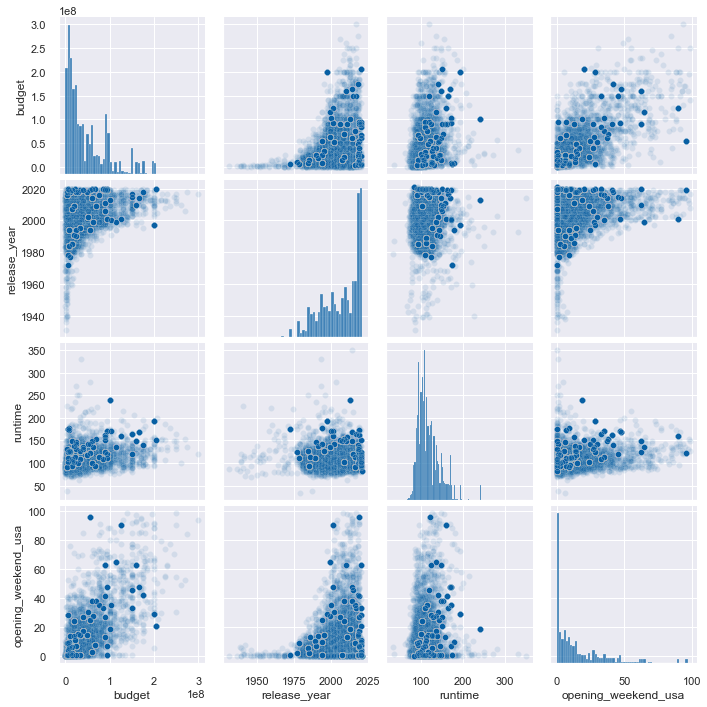

In [585]:
# sns.pairplot(c_movie_df[['opening_weekend_usa','budget','release_year','runtime']], plot_kws=dict(alpha=.1, edgecolor='none'))
sns.pairplot(c_movie_df[['budget','release_year','runtime','opening_weekend_usa']],plot_kws=dict(alpha=.1))

In [909]:
c_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 4 to 4998
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   opening_weekend_usa  3667 non-null   float64
 1   budget               3244 non-null   float64
 2   runtime              3666 non-null   float64
 3   release_year         3667 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 143.2 KB


(['budget(USD)', 'release year', 'runtime(min)', 'opening_weekend_usa ($M)'],
 ['budget(USD)', 'release year', 'runtime(min)', 'opening_weekend_usa ($M)'])

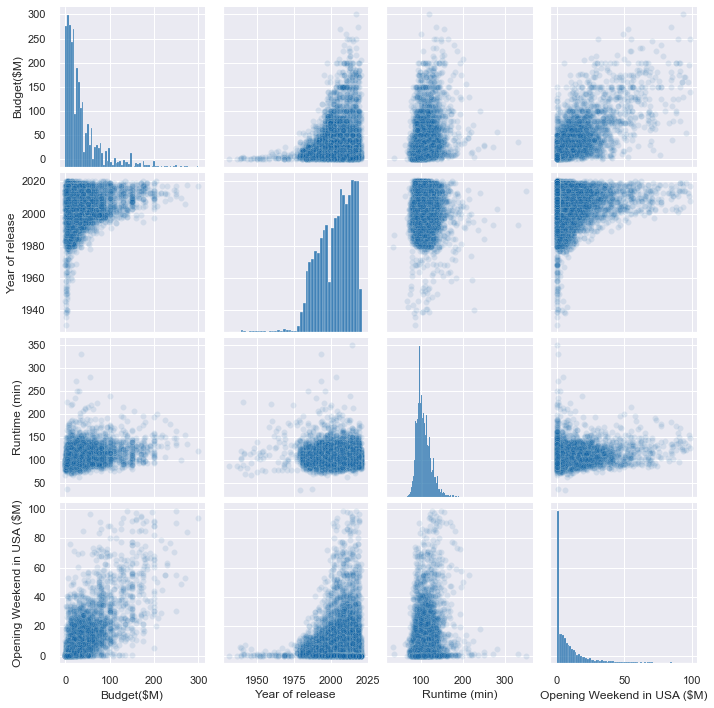

In [586]:
scatter_df = all_df[['budget','release_year','runtime','opening_weekend_usa']].copy()
scatter_df['budget'] = scatter_df['budget']/1e6
scatter_df.rename(columns={'budget': 'Budget($M)', 'release_year':'Year of release', 'runtime':'Runtime (min)',\
'opening_weekend_usa': 'Opening Weekend in USA ($M)'},inplace=True)
fig = sns.pairplot(scatter_df,plot_kws=dict(alpha=.1))
    
# for i in range(len(xlabels)):
#     for j in range(len(ylabels)):
#         g.axes[j,i].xaxis.set_label_text(xlabels[i])
#         g.axes[j,i].yaxis.set_label_text(ylabels[j])

# xlabels = ['budget(USD)','release year','runtime(min)','opening_weekend_usa ($M)']
# ylabels = ['budget(USD)','release year','runtime(min)','opening_weekend_usa ($M)']


# i=3
# for j in range(len(ylabels)):
#         g.axes[j,i].xaxis.set_label_text(xlabels[i])
#         g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.show()

In [587]:
fig.savefig('../plot/pairplot.pdf', bbox_inches='tight', transparent = True)

### Baseline Model
Only consider the continuous predictors and use 'opening_weekend_usa'.

In [588]:
# Separate features and target variable

def get_Xy(df):
    
    df = df.dropna()
    
    target = 'opening_weekend_usa'
#     target = 'rating'
#     target = 'gross_usa'
    all_column = df.columns.values.tolist()
    all_column.remove(target)

    y = df[target]
    X = df[all_column]
    
    return X, y

In [595]:
X, y = get_Xy(c_movie_df)

In [596]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
#     # perform train/val split
#     X_train, X_val, y_train, y_val = \
#         train_test_split(X, y, test_size=0.2, random_state=25)

    # train/val/test split
    # holding test set
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    print(f'RMSE: {rmse:.2f}')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
        
    
    # Visualization
    fig, ax = plt.subplots(1, 1)
    plt.scatter(y_val, y_pred, alpha=0.4)

    ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
    ax.set_ylabel('Prediction (USD)',fontsize=20)
    ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

    x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)
    
    y=x
    plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
    plt.ylim(0,)
    plt.xlim(0,)
    return fig


Train R^2 score was: 0.5158105402526112
Validation R^2 score was: 0.48979529212513884
Feature coefficient results: 

RMSE: 10.87
budget : 0.00
runtime : -0.03
release_year : 0.10


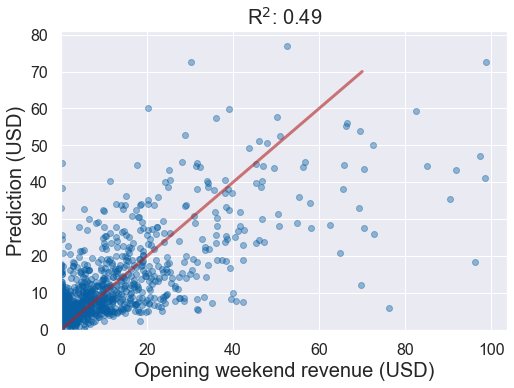

In [597]:
# Reports for model with all features
fig = split_and_validate(X,y)

In [598]:
fig.savefig('../plot/lr_prediction.pdf', bbox_inches='tight', transparent = True)

In [965]:
# # Reports for model with features of movie only
# X, y = get_Xy(c_movie_df)
# split_and_validate(X,y)

In [310]:
def get_score(X_train,X_val,y_train,y_val):
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    
    # report results
    print('\nTrain R^2 score was:', train_score)
    print('Validation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    print(f'RMSE: {rmse:.2f}')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
        
    
    # Visualization
    fig, ax = plt.subplots(1, 1)
    plt.scatter(y_val, y_pred, alpha=0.4)

    ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
    ax.set_ylabel('Prediction (USD)',fontsize=20)
    ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

    x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)
    
    y=x
    plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
    plt.ylim(0,)
    plt.xlim(0,)
    return fig


Train R^2 score was: 0.5026235483925886
Validation R^2 score was: 0.4756047144162102
Feature coefficient results: 

RMSE: 10.53
budget : 0.00
runtime : -0.04
release_year : 0.05


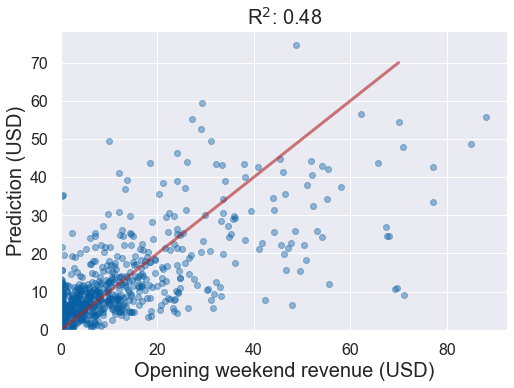

In [599]:
fig = get_score(X_train,X_val,y_train,y_val)

In [601]:
fig.savefig('../plot/lr_prediction.pdf', bbox_inches='tight', transparent = True)

### Cross-validation

In [600]:
# Will not use X_test, y_test
lr = LinearRegression()

X, y = get_Xy(c_movie_df)

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.4825511641625698
[0.48832595 0.56262556 0.43030156 0.46317734 0.46832541]


In [350]:
# result = cross_val_score(lr, X_train, y_train, # estimator, features, target
#                 cv=5, # number of folds 
#                 scoring='r2') # scoring metric

In [351]:
# # mean of val_score
# print("Meam of validation score is:", np.mean(result))
# print(result)

In [ ]:
cross_val_score()

### Find outliers and evaluate the model again

## 2. Basic Feature Engineering

### Split the data set into Train / Validation / Test sets

In [833]:
# Choose df
# X, y = get_Xy(c_movie_df)
X, y = get_Xy(c_movie_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

### * Scaled Features

In [834]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [835]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
lr.score(X_train_scaled,y_train), lr.score(scaler.transform(X_val),y_val)

(0.5158105402526112, 0.4897952921251387)

In [836]:
coef = pd.DataFrame(list(zip((con_feature),lr.coef_)),index=con_feature,columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
coef

,Feature,Coefficient
budget,budget,10.709417
release_year,release_year,1.097222
runtime,runtime,-0.559933


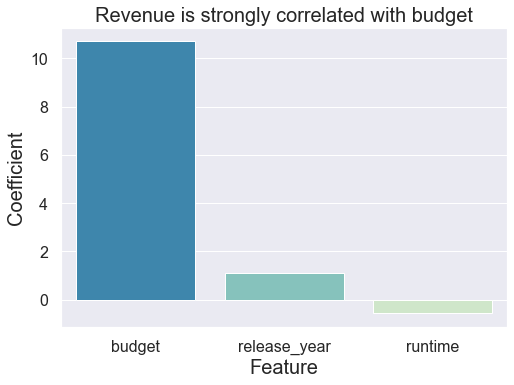

In [837]:
coef = pd.DataFrame(list(zip((con_feature),lr.coef_)),index=con_feature,columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)

# Generate coef plots for the 3 continuous features
# plt.style.use('seaborn')
import matplotlib.style as style
# style.use('seaborn-poster') #sets the size of the charts
# style.use('seaborn-dark')
p = sns.color_palette("GnBu_r",3)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.set_palette(p)
sns.barplot(x="Feature", y= 'Coefficient', data = coef)
ax.set_title('Revenue is strongly correlated with budget',fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Coefficient',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
# ax.set_xticklabels(['0','50k','100k','150k','200k','250k'])

fig.savefig('../plot/lr_coef.pdf', bbox_inches='tight', transparent=True)
# fig.savefig('Top_station2.svg', format='svg')

In [289]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.41182725698679434
[0.43368163 0.46091221 0.39483961 0.37757285 0.39212999]


### * Polynomial Fearues
(degree=2): Adding interaction terms and second order feature.

In [740]:
# Choose df
# X, y = get_Xy(c_movie_df)
X, y = get_Xy(c_movie_df)

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)

In [741]:
# Only with interaction terms
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = True)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.5190274835985377, 0.49423716229659553)

In [742]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train_poly_scaled, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.5119743723779819
[0.54846713 0.51176749 0.54140874 0.46782973 0.49039878]


In [743]:
# increased train score, but decreased val score.
# overfitting

In [744]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only = False)

X_train_poly_scaled = scaler.fit_transform(poly.fit_transform(X_train))
X_val_poly_scaled = scaler.transform(poly.transform(X_val))

lr.fit(X_train_poly_scaled,y_train)
lr.score(X_train_poly_scaled,y_train), lr.score(X_val_poly_scaled,y_val)

(0.5201297884997611, 0.49287054547738385)

In [745]:
feature = poly.get_feature_names(con_feature)
list(zip((feature),lr.coef_))

[('1', 0.0),
 ('budget', -148.25263941182936),
 ('runtime', 47.19931516983088),
 ('release_year', -39.042598105790645),
 ('budget^2', -0.4727809827982361),
 ('budget runtime', 4.395566298673294),
 ('budget release_year', 155.50190954735578),
 ('runtime^2', -2.6556393357248567),
 ('runtime release_year', -45.861857401101055),
 ('release_year^2', 41.1035884614439)]

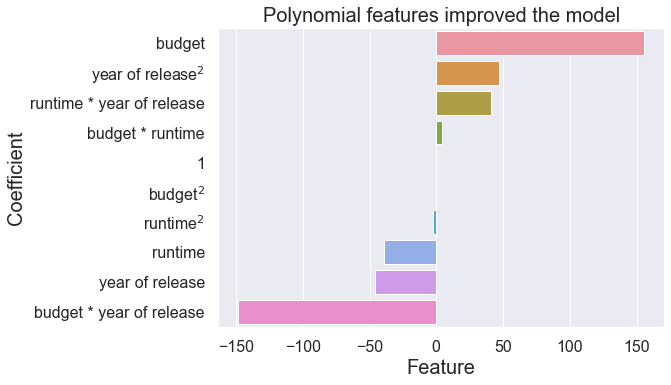

In [746]:
coef = pd.DataFrame(list(zip((feature),lr.coef_)),index= feature,columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)

# Generate coef plots for the 3 continuous features
# plt.style.use('seaborn')
import matplotlib.style as style
# style.use('seaborn-poster') #sets the size of the charts
# style.use('seaborn-dark')
p = sns.color_palette("GnBu_r",9)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.set_palette(p)
sns.barplot(y="Feature", x= 'Coefficient', data = coef,orient='h')
ax.set_title('Polynomial features improved the model',fontsize=20)
ax.set_xlabel('Feature',fontsize=20)
ax.set_ylabel('Coefficient',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_yticklabels(['budget','year of release$^2$','runtime * year of release','budget * runtime','1',\
                    'budget$^2$','runtime$^2$','runtime','year of release','budget * year of release'])

fig.savefig('../plot/lr_poly_coef.pdf', bbox_inches='tight', transparent=True)
# fig.savefig('Top_station2.svg', format='svg')

In [747]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)
result = cross_val_score(lr, X_train_poly_scaled, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.5118102710973107
[0.54726774 0.51004502 0.54384476 0.46839192 0.48950192]



Train R^2 score was: 0.5201297884997611
Validation R^2 score was: 0.49287054547738385
Feature coefficient results: 

RMSE: 10.83
budget : 0.00
runtime : -148.25
release_year : 47.20


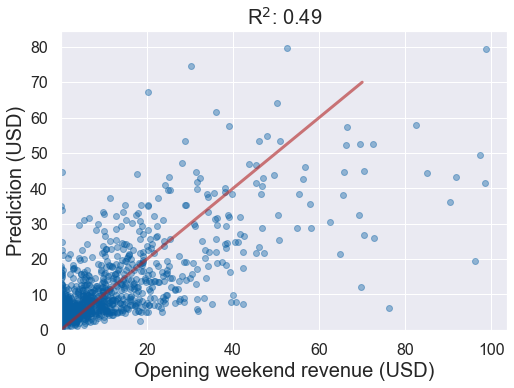

In [748]:
fig = get_score(X_train_poly_scaled,X_val_poly_scaled,y_train,y_val)

In [749]:
fig.savefig('../plot/lr_poly_prediction.pdf', bbox_inches='tight', transparent=True)

## 3. Intermediate Feature Engineering: Categorical features
Use `OneHotEncoder` or `pd.get_dummies(df['column'])` to treat categorical variables

### 1. genre

In [617]:
all_df.info(), con_feature

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6347 entries, 3 to 5098
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          6347 non-null   object        
 1   rating               6347 non-null   float64       
 2   vote                 6347 non-null   float64       
 3   MPAA                 6347 non-null   object        
 4   genre                6347 non-null   object        
 5   release_date         6347 non-null   datetime64[ns]
 6   metascore            2087 non-null   float64       
 7   keywords             6347 non-null   object        
 8   budget               5125 non-null   float64       
 9   opening_weekend_usa  6347 non-null   float64       
 10  gross_usa            6346 non-null   float64       
 11  gross_world          6339 non-null   float64       
 12  runtime              6331 non-null   float64       
 13  distributor          6339 non-nul

(None, ['budget', 'runtime', 'release_year'])

In [618]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['genre']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [619]:

# Train set
# Convert genre to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


#Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


#Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]


# # Test set
# # Convert genre to dummies
# X_test_genre = X_test['genre'].str.join(sep='*').str.get_dummies(sep='*')

# # Scaling continuous variables
# X_test_con = X_test[con_feature]
# X_test_con_scaled = scaler.transform(X_test_con)
# X_test_con_scaled_df = pd.DataFrame(X_test_con_scaled, columns=X_test_con.columns, index=X_test_con.index)

# #Combine
# X_test = pd.concat([X_test_genre,X_test_con_scaled_df],axis=1)
# keep2 = list(set(keep).intersection(set(X_test.columns)))
# X_test = X_test[keep2]

In [620]:
X_train.shape, X_val.shape, X_test.shape

((3067, 30), (1023, 30), (1023, 4))

In [621]:
# X_train


Train R^2 score was: 0.507568509167002
Validation R^2 score was: 0.5152598508487973
Feature coefficient results: 

RMSE: 10.93
budget : 0.70
runtime : 0.62
release_year : -2.28
genre : 1.20


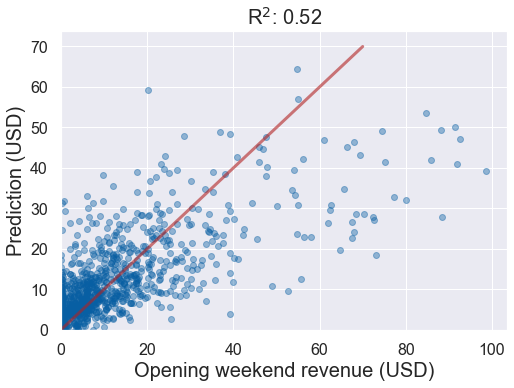

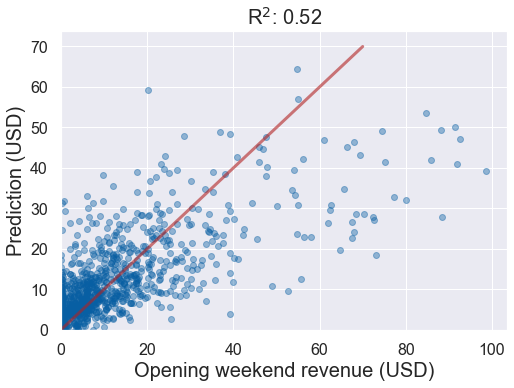

In [622]:
get_score(X_train, X_val, y_train, y_val) # only scaling


Train R^2 score was: 0.507568509167002
Validation R^2 score was: 0.5152598508487973
Feature coefficient results: 

RMSE: 10.93
budget : 0.70
runtime : 0.62
release_year : -2.28
genre : 1.20


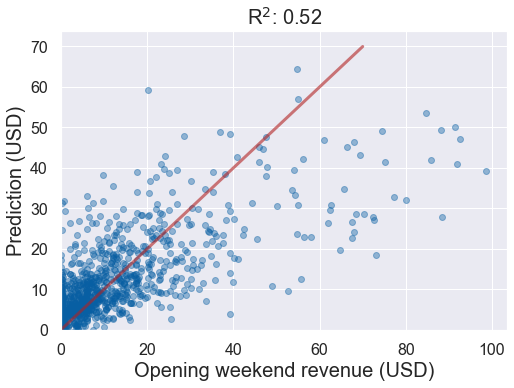

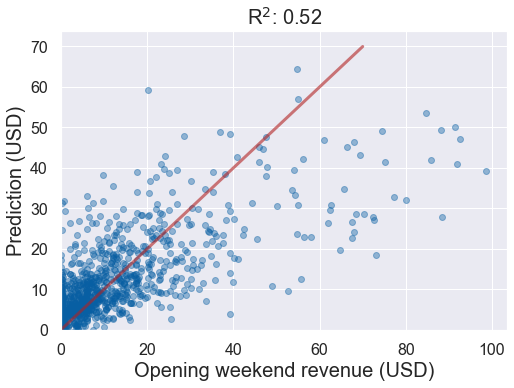

In [623]:
get_score(X_train, X_val, y_train, y_val) # scaling+poly

In [473]:
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.5067568786834221

In [474]:
lr.coef_

array([-7.72177399e-02, -4.05002720e+00, -9.38050375e+00,  2.95478304e+00,
       -5.01457439e+00,  1.31222977e+00, -2.12696135e+00,  3.15522885e+00,
        4.48510426e+00,  7.10289435e+00, -1.07182074e+00,  8.43127447e-01,
       -2.21217487e+00,  8.76016906e-01,  5.20689654e+00, -2.71009090e+00,
        9.50754151e-01, -3.95755368e-01,  1.64083077e+00, -8.00482319e+00,
       -4.88498131e-15,  4.53437763e+00, -2.43790730e+00,  1.20522901e+01,
       -4.28456090e+00,  1.17328787e+01, -1.44995335e+00,  8.86493577e+00])

In [45]:
# pd.DataFrame(list(zip(X_train.columns,lr.coef_))).sort_values(by=[1],ascending=False)

In [475]:
lr.score(X_val,y_val)

0.4792009156790874

In [476]:
X_train.shape,y_train.shape

((6207, 28), (6207,))

In [477]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.5033021967591045
[0.46196439 0.52838172 0.51131094 0.48702553 0.5278284 ]


### 2. MPAA rating

In [624]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['MPAA']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [625]:
# Train set
# Convert genre to dummies
X_train_genre = X_train['MPAA'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['MPAA'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)


# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.47264119095949386
Validation R^2 score was: 0.48766038023903036
Feature coefficient results: 

RMSE: 11.24
budget : 2.29
runtime : 9095817961856.39
release_year : -1.28
MPAA : -7263063953776.86


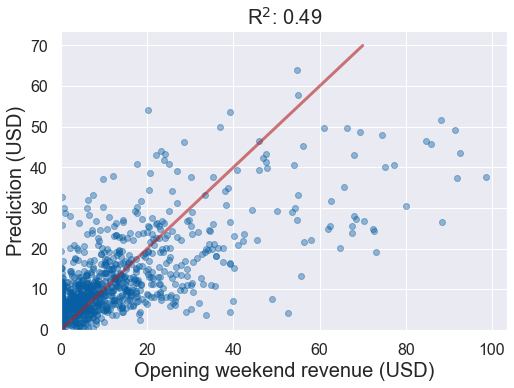

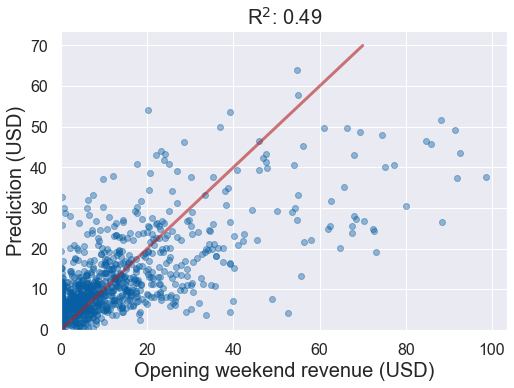

In [626]:
get_score(X_train, X_val, y_train, y_val)

In [627]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: -6.240355622179401e+23
[ 4.70111665e-01 -3.05598604e+23  3.85331988e-01  5.24364061e-01
 -2.81457921e+24]


In [628]:
# all_df.info()

### 3. language

In [629]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['language']]
# df = all_df[['rating'] + con_feature + con_book_feature + ['genre']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [630]:
# Train set
# Convert genre to dummies
X_train_genre = X_train['language'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['language'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)


# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.4853000309022606
Validation R^2 score was: 0.4823364476324963
Feature coefficient results: 

RMSE: 11.30
budget : 11.00
runtime : -11.97
release_year : -8.32
language : -3.01


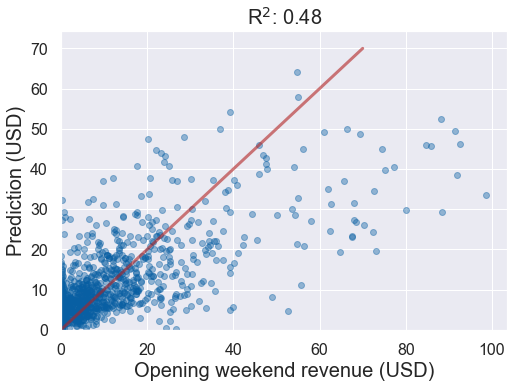

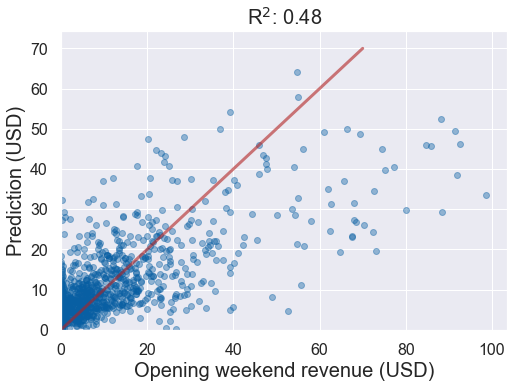

In [631]:
get_score(X_train, X_val, y_train, y_val)

In [632]:
# X_train.info()

In [633]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: -1.41956651055498e+24
[-1.18144236e+24  4.53225580e-01 -5.85236583e+24 -6.40243621e+22
  4.77976960e-01]


### 4. country

In [634]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['country']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [635]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]

In [636]:
pd.DataFrame(X_train_genre.sum()).sort_values(by=[0],ascending=False)

,0
USA,3067
UK,477
Canada,258
Germany,226
France,195
...,...
Monaco,1
Namibia,1
Nepal,1
NorthKorea,1



Train R^2 score was: 0.4995526947628559
Validation R^2 score was: 0.4868459447030947
Feature coefficient results: 

RMSE: 11.42
budget : 1.10
runtime : -7.97
release_year : -2.44
country : -0.20


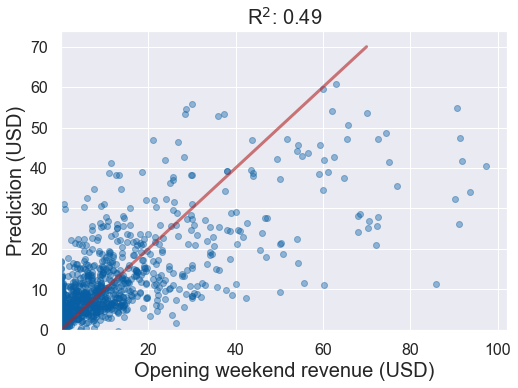

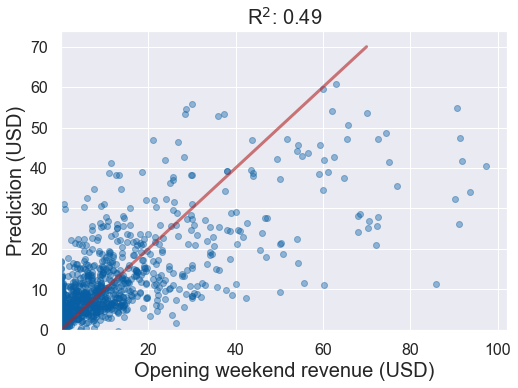

In [637]:
get_score(X_train, X_val, y_train, y_val)

In [638]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: -3.4307140841796566e+21
[-1.71535704e+22  4.81715776e-01  4.91719916e-01  4.56225887e-01
  4.23469180e-01]


### 5. distributor

In [639]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['distributor']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [640]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['distributor'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['distributor'].str.join(sep='*').str.get_dummies(sep='*')

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.49798298597665624
Validation R^2 score was: 0.5063688742058011
Feature coefficient results: 

RMSE: 11.20
budget : -4.48
runtime : 0.94
release_year : -0.23
distributor : 2.87


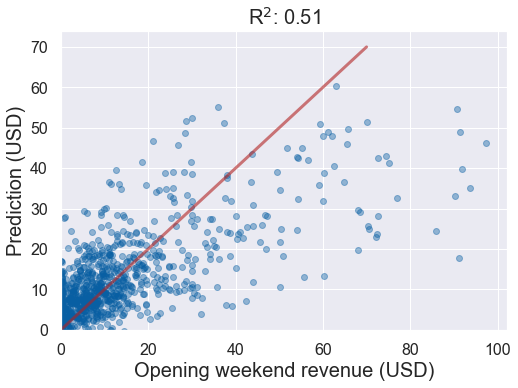

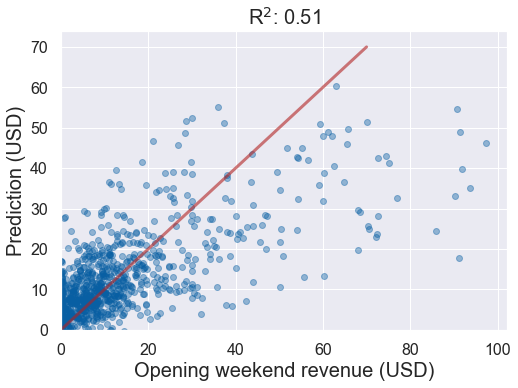

In [641]:
get_score(X_train, X_val, y_train, y_val)

In [642]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Meam of validation score is:", np.mean(result))
print(result)

Meam of validation score is: 0.48189392291362126
[0.50256441 0.51345822 0.49670716 0.45808045 0.43865937]


### 7. actor

In [643]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['star']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [644]:
# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)[keep]
X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)[keep]


Train R^2 score was: 0.50033184489424
Validation R^2 score was: 0.5007383500905185
Feature coefficient results: 

RMSE: 11.27
budget : -0.33
runtime : 1.80
release_year : 2.15
star : 0.67


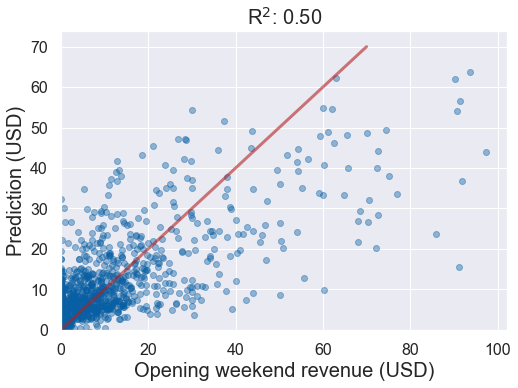

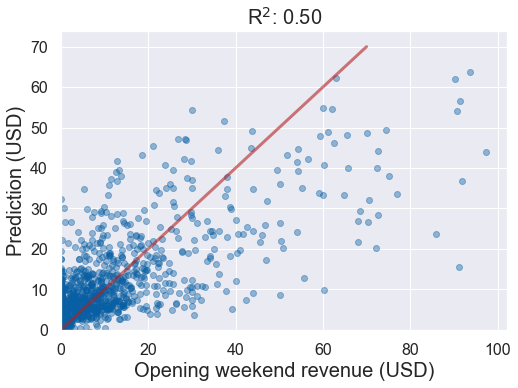

In [645]:
get_score(X_train, X_val, y_train, y_val)

In [646]:
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + ['star']]
# df = all_df[['opening_weekend_usa'] + con_feature + ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [647]:
#
## scaling + poly

# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert genre to dummies
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


#Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


#Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [648]:
# X_train_genre


Train R^2 score was: 0.5059286836174248
Validation R^2 score was: 0.5068792207357649
Feature coefficient results: 

RMSE: 11.20
budget : -0.27
runtime : 1.21
release_year : 0.33
star : 2.21


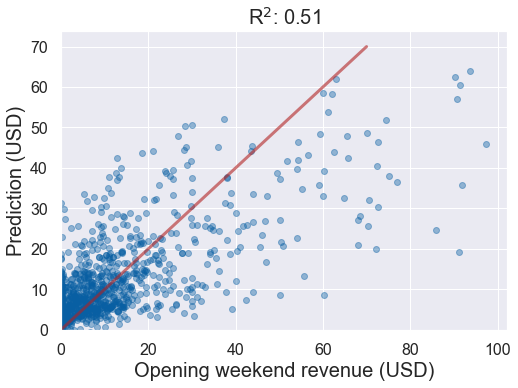

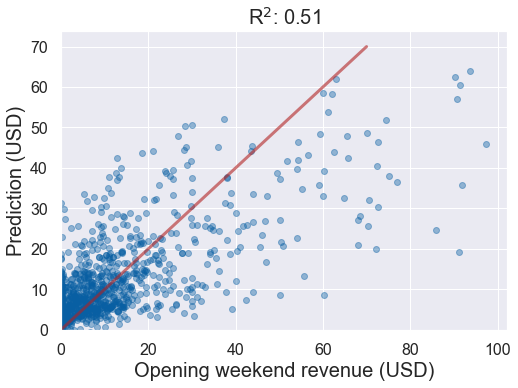

In [649]:
get_score(X_train, X_val, y_train, y_val)

In [502]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.768830522044256
[0.76738282 0.73092739 0.79747949 0.77506024 0.77330267]


### 6. all categorical variables

#### * all categorical variables + scaling

In [654]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [655]:

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)
            
            
# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [656]:
X_train.shape, X_val.shape

((3067, 398), (1023, 398))


Train R^2 score was: 0.5943157143384132
Validation R^2 score was: -5.903180431099947e+20
Feature coefficient results: 

RMSE: 387439044602.37
budget : 8.27
runtime : 2.38
release_year : 2.43
genre : -4.05
MPAA : 0.51
language : -1.44
country : -1.82
distributor : -1.28
star : -1.29


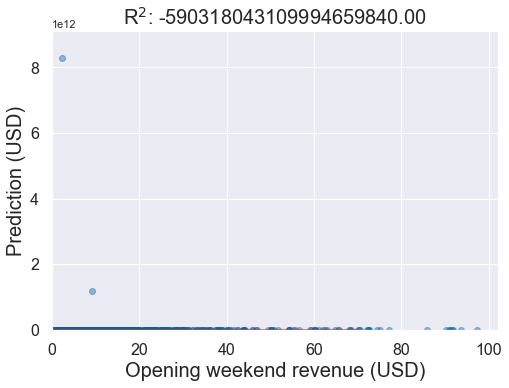

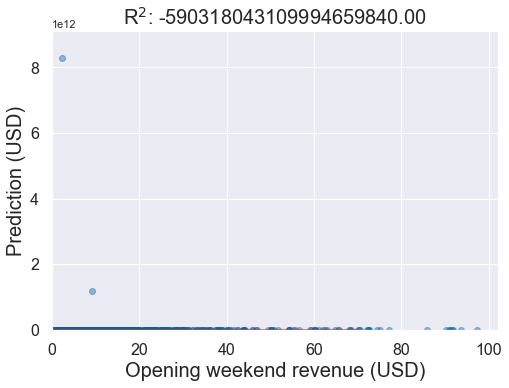

In [657]:
get_score(X_train, X_val, y_train, y_val)

In [658]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: -2.95719104077659e+21
[-9.17950968e+18 -4.73332411e+20 -3.07338592e+20 -1.29135332e+22
 -1.08257149e+21]


#### * All categorical variables + scaling + polynomial features

In [751]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [752]:

# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]


# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = scaler.fit_transform(X_train_con)
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns=X_train_con.columns, index=X_train_con.index)

X_train_poly = poly.fit_transform(X_train_con_scaled)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train_con.columns), index=X_train_con.index)


# Combine
# X_train = pd.concat([X_train_genre,X_train_con_scaled_df],axis=1)
X_train = pd.concat([X_train_genre,X_train_poly_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]


# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = scaler.transform(X_val_con)
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns=X_val_con.columns, index=X_val_con.index)

X_val_poly = poly.transform(X_val_con_scaled)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names(X_val_con.columns), index=X_val_con.index)


# Combine
# X_val = pd.concat([X_val_genre,X_val_con_scaled_df],axis=1)
X_val = pd.concat([X_val_genre,X_val_poly_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

In [753]:
X_train.shape, X_val.shape

((3067, 94), (1023, 94))

In [754]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.5059286836174248

In [755]:
list(zip(poly.get_feature_names(X_val_con.columns), lr.coef_))

[('1', -0.26890519302343574),
 ('budget', 1.2131080567933656),
 ('runtime', 0.32613999379733527),
 ('release_year', 2.214931750071971),
 ('budget^2', 0.3927885211165587),
 ('budget runtime', 1.3472443395152185),
 ('budget release_year', -5.1664619655908774),
 ('runtime^2', -3.7082271593823366),
 ('runtime release_year', -8.68435817927874),
 ('release_year^2', -3.115101881022942)]


Train R^2 score was: 0.5059286836174248
Validation R^2 score was: 0.5068792207357649
Feature coefficient results: 

RMSE: 11.20
budget : -0.27
runtime : 1.21
release_year : 0.33
genre : 2.21
MPAA : 0.39
language : 1.35
country : -5.17
distributor : -3.71
star : -8.68


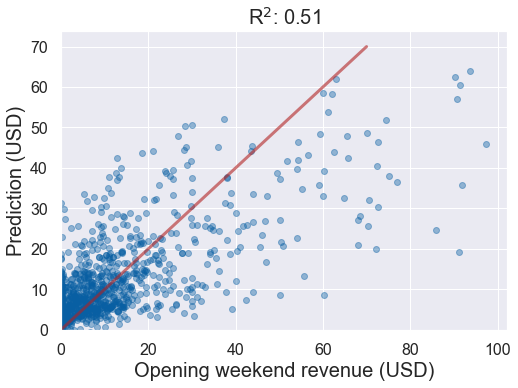

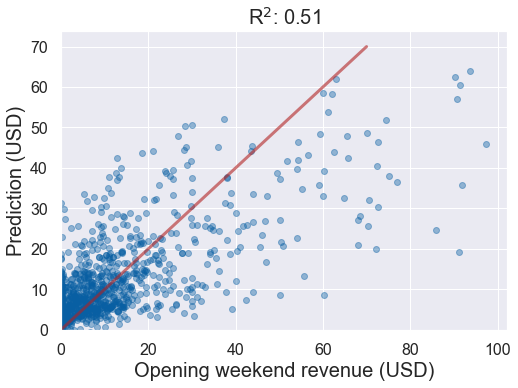

In [756]:
get_score(X_train, X_val, y_train, y_val)

In [665]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: 0.43576965352179686
[0.43457095 0.50284335 0.40861009 0.44470535 0.38811852]


In [320]:
# all_variable_score('movie only')

In [321]:
# all_variable_score('movie+book')

## 4. Incorporate Polynomial Features

In [757]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only = True)


# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)


# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])
X_train_genre = X_train['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_train_genre.columns).intersection(set(actor_list)))
X_train_genre = X_train_genre[keep_actor]

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = poly.fit_transform(scaler.fit_transform(X_train_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns = poly_column,\
                                     index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])
X_val_genre = X_val['star'].str.join(sep='*').str.get_dummies(sep='*')
keep_actor = list(set(X_val_genre.columns).intersection(set(actor_list)))
X_val_genre = X_val_genre[keep_actor]

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = poly.transform(scaler.fit_transform(X_val_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns = poly_column,\
                                   index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]


Train R^2 score was: 0.5997325573293624
Validation R^2 score was: -7.472065916353671e+20
Feature coefficient results: 

RMSE: 435893811729.57
budget : 6.05
runtime : 2.33
release_year : 2.07
genre : -3.65
MPAA : 0.76
language : -0.97
country : -1.49
distributor : -2.01
star : -1.19


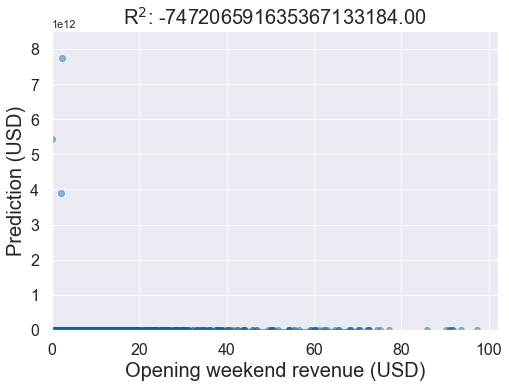

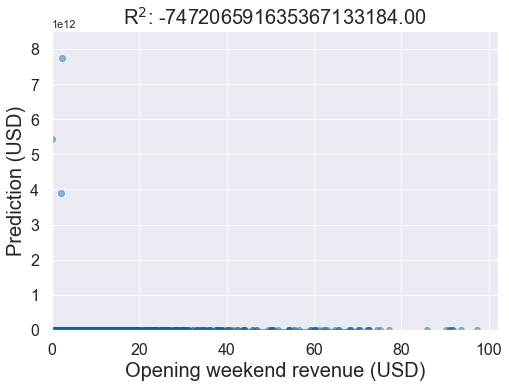

In [758]:
# only adding interaction term
get_score(X_train, X_val, y_train, y_val)

In [759]:
# Cross-validation
# Will not use X_test, y_test
lr = LinearRegression()
# X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)
result = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric
# mean of val_score
print("Mean of validation score is:", np.mean(result))
print(result)

Mean of validation score is: -1.0253417764727867e+22
[-2.56252409e+19 -8.01655223e+20 -2.12941884e+22 -2.60743721e+21
 -2.65381828e+22]



Train R^2 score was: 0.5983028429491462
Validation R^2 score was: -6.77494975038467e+20
Feature coefficient results: 

RMSE: 415062402411.13
budget : 1.19
runtime : 0.37
release_year : 0.35
genre : -0.49
MPAA : -1.78
language : 1.78
country : -6.41
distributor : -11.09

Train R^2 score was: 0.5850113963538882
Validation R^2 score was: -2.9925762740645857e+18
Feature coefficient results: 

RMSE: 27585634043.57
budget : -6.40
runtime : 2.63
release_year : -2.38
genre : -6.35
MPAA : 1.34
language : -3.20
country : 19.00
distributor : -1.16

Train R^2 score was: 0.5850113963538882
Validation R^2 score was: -3.21345044008151e+18
Feature coefficient results: 

RMSE: 27585634043.47
budget : -6.40
runtime : 2.63
release_year : -2.38
genre : -6.35
MPAA : 1.34
language : -3.20
country : 19.00
distributor : -1.16


(<Figure size 576x396 with 1 Axes>, <Figure size 576x396 with 1 Axes>)

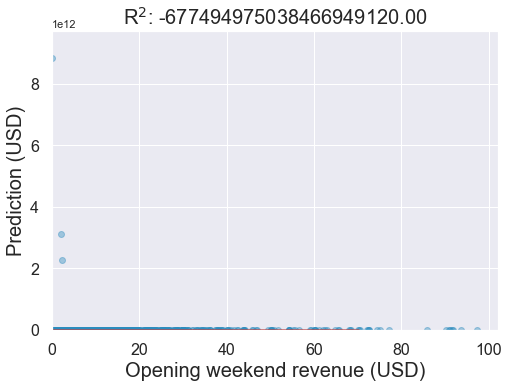

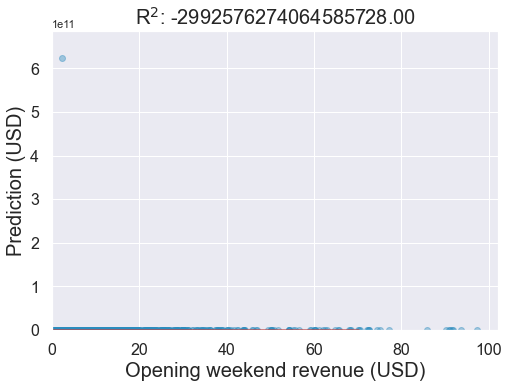

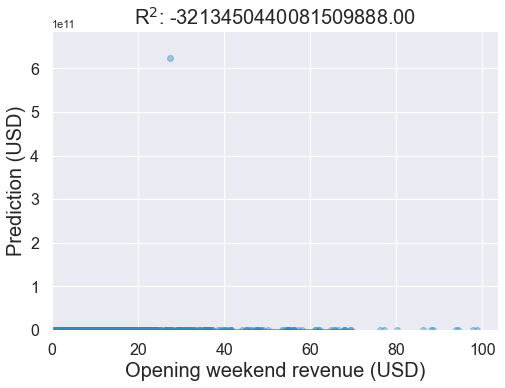

In [840]:

###
### Including square term


from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only = False)


# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)



# train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

# book movie test set
# X_test = test_df[con_feature + \
#             ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# y_test = test_df['opening_weekend_usa']


# Train set
# Convert all cat to dummies
X_train_genre = X_train['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_train_MPAA = pd.get_dummies(X_train['MPAA'])
X_train_language= X_train['language'].str.join(sep='*').str.get_dummies(sep='*')
X_train_country = X_train['country'].str.join(sep='*').str.get_dummies(sep='*')
X_train_distributor = pd.get_dummies(X_train['distributor'])

# Scaling continuous variables
X_train_con = X_train[con_feature]
X_train_con_scaled = poly.fit_transform(scaler.fit_transform(X_train_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_train_con_scaled_df = pd.DataFrame(X_train_con_scaled, columns = poly_column,\
                                     index=X_train_con.index)

#Combine
X_train = pd.concat([X_train_genre,X_train_MPAA, X_train_language, X_train_country, X_train_distributor,\
                     X_train_con_scaled_df],axis=1)



# Val set
# Convert genre to dummies
X_val_genre = X_val['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_val_MPAA = pd.get_dummies(X_val['MPAA'])
X_val_language= X_val['language'].str.join(sep='*').str.get_dummies(sep='*')
X_val_country = X_val['country'].str.join(sep='*').str.get_dummies(sep='*')
X_val_distributor = pd.get_dummies(X_val['distributor'])

# Scaling continuous variables
X_val_con = X_val[con_feature]
X_val_con_scaled = poly.transform(scaler.fit_transform(X_val_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_val_con_scaled_df = pd.DataFrame(X_val_con_scaled, columns = poly_column,\
                                   index=X_val_con.index)

#Combine
X_val = pd.concat([X_val_genre,X_val_MPAA, X_val_language, X_val_country, X_val_distributor, \
                   X_val_con_scaled_df],axis=1)

# Find the common columns to keep
keep = list(set(X_train.columns).intersection(set(X_val.columns)))
X_train = X_train[keep]
X_val = X_val[keep]

get_score(X_train, X_val, y_train, y_val)




# Test set
# Convert genre to dummies
X_test_genre = X_test['genre'].str.join(sep='*').str.get_dummies(sep='*')
X_test_MPAA = pd.get_dummies(X_test['MPAA'])
X_test_language= X_test['language'].str.join(sep='*').str.get_dummies(sep='*')
X_test_country = X_test['country'].str.join(sep='*').str.get_dummies(sep='*')
X_test_distributor = pd.get_dummies(X_test['distributor'])

# Scaling continuous variables
X_test_con = X_test[con_feature]
X_test_con_scaled = poly.transform(scaler.fit_transform(X_test_con)) # standardscalar and polyfeatrues
poly_column = poly.get_feature_names(con_feature) # poly coef columns
X_test_con_scaled_df = pd.DataFrame(X_test_con_scaled, columns = poly_column,\
                                   index=X_test_con.index)

#Combine
X_test = pd.concat([X_test_genre,X_test_MPAA, X_test_language, X_test_country, X_test_distributor, \
                   X_test_con_scaled_df],axis=1)

# Find the common columns to keep
keep2 = list(set(X_test.columns).intersection(set(keep)))
X_train = X_train[keep2]
X_val = X_val[keep2]
X_test = X_test[keep2]

get_score(X_train, X_val, y_train, y_val),get_score(X_train, X_test, y_train, y_test)

### Find outliers and evaluate the model again

In [808]:
lc_df = all_df[['movie_title'] + ['opening_weekend_usa'] + con_feature + 
               ['genre','release_year','rating']].copy().dropna()

In [809]:
lc_df.shape

(5113, 8)

In [810]:
lc_df.drop_duplicates(subset=['movie_title','release_year'],keep='first',inplace=True)

In [811]:
X = lc_df[con_feature + ['rating']]
y = lc_df['opening_weekend_usa']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=58)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)
lc_df['res'] = lr.predict(lc_df[con_feature + ['rating']])-lc_df['opening_weekend_usa']

In [812]:
res1 = lc_df[['movie_title','genre','res']].sort_values(['res']).dropna().head(100)
res1.head(15)

,movie_title,genre,res
46,Joker,"[Crime, Drama, Thriller]",-76.432654
234,Fifty Shades of Grey,"[Drama, Romance, Thriller]",-74.037323
1600,Halloween,"[Crime, Horror, Thriller]",-69.834310
457,It Chapter Two,"[Drama, Fantasy, Horror]",-68.496035
329,Us,"[Horror, Mystery, Thriller]",-62.068580
325,Harry Potter and the Chamber of Secrets,"[Adventure, Family, Fantasy]",-61.293593
1509,The Hangover Part II,[Comedy],-61.176890
166,Twilight,"[Drama, Fantasy, Romance]",-58.788479
2725,Despicable Me 2,"[Animation, Adventure, Comedy]",-58.753424
1958,Pitch Perfect 2,"[Comedy, Music]",-58.459170


In [826]:
res2 = lc_df[['movie_title','genre','res']].sort_values(['res']).tail(100)
res2.tail(20).sort_values(['res'],ascending=False)

,movie_title,genre,res
1502,The Protector,"[Action, Crime, Drama]",51.849885
409,Frozen,"[Animation, Adventure, Comedy]",44.472325
1443,John Carter,"[Action, Adventure, Sci-Fi]",39.555387
2390,47 Ronin,"[Action, Drama, Fantasy]",39.531068
280,The Revenant,"[Action, Adventure, Drama]",38.792060
3,Tenet,"[Action, Sci-Fi, Thriller]",38.237715
2963,Brother Bear,"[Animation, Adventure, Comedy]",37.601438
2826,Mars Needs Moms,"[Animation, Action, Adventure]",36.411824
2910,The 13th Warrior,"[Action, Adventure, History]",34.992287
793,King Arthur: Legend of the Sword,"[Action, Adventure, Drama]",34.921252


In [1013]:
res1 = lc_df[['movie_title','release_year','genre','res']].sort_values(['res']).head(100)
res1.head(20)

,movie_title,release_year,release_year,genre,res
46,Joker,2019,2019,"[Crime, Drama, Thriller]",-76.857885
234,Fifty Shades of Grey,2015,2015,"[Drama, Romance, Thriller]",-71.294337
457,It Chapter Two,2019,2019,"[Drama, Fantasy, Horror]",-68.088223
1600,Halloween,2018,2018,"[Crime, Horror, Thriller]",-67.851580
325,Harry Potter and the Chamber of Secrets,2002,2002,"[Adventure, Family, Fantasy]",-62.206409
1509,The Hangover Part II,2011,2011,[Comedy],-61.233656
329,Us,2019,2019,"[Horror, Mystery, Thriller]",-60.488081
225,Iron Man,2008,2008,"[Action, Adventure, Sci-Fi]",-60.190488
2725,Despicable Me 2,2013,2013,"[Animation, Adventure, Comedy]",-59.199101
311,Logan,2017,2017,"[Action, Drama, Sci-Fi]",-59.194090


In [1016]:
res2 = lc_df[['movie_title','release_year','genre','res']].sort_values(['res']).tail(100)
res2.tail(20)

,movie_title,release_year,release_year,genre,res
496,The Aviator,2004,2004,"[Biography, Drama]",28.124680
1896,The Adventures of Tintin,2011,2011,"[Animation, Action, Adventure]",28.376484
34,1917,2020,2020,"[Drama, Thriller, War]",28.662200
888,Jupiter Ascending,2015,2015,"[Action, Adventure, Sci-Fi]",28.925784
915,Battleship,2012,2012,"[Action, Adventure, Sci-Fi]",29.415266
1016,Hugo,2011,2011,"[Drama, Family, Fantasy]",29.740944
1426,The Princess and the Frog,2009,2009,"[Animation, Adventure, Comedy]",30.101007
1046,Valerian and the City of a Thousand Planets,2017,2017,"[Action, Adventure, Fantasy]",30.789993
2838,Live by Night,2017,2017,"[Action, Crime, Drama]",31.177133
793,King Arthur: Legend of the Sword,2017,2017,"[Action, Adventure, Drama]",32.303688


In [886]:
res_df = pd.concat([res1,res2],axis=0)
res_movie = res.movie_title.tolist()

In [827]:
all_df[all_df.movie_title == "Kiki's Delivery Service"]

,movie_title,rating,vote,MPAA,genre,release_date,metascore,keywords,budget,opening_weekend_usa,...,distributor,language,country,director,writer,star,link_d,link_w,link_s,release_year
2063,Kiki's Delivery Service,7.8,123657.0,G,"[Animation, Adventure, Drama]",1990-12-20,83.0,"[witch, cat, studio ghibli, goodwill, magic]",800000000.0,0.352556,...,Kiki'sDeliveryServiceProductionCommittee,"[Japanese, English]","[Japan, USA]",Hayao Miyazaki,"[Eiko Kadono, Hayao Miyazaki]","[Kirsten Dunst, Minami Takayama, Rei Sakuma]",/name/nm0594503/,"[/name/nm0434395/, /name/nm0594503/]","[/name/nm0000379/, /name/nm0847439/, /name/nm0...",1990


## 4. Regularization

In [670]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

### * Ridge

In [671]:
## Fit a Ridge model on the standardized data

# ridge_model = Ridge(alpha = 0.001)
# ridge_model.fit(X_train,y_train)
# list(zip(X_train.columns, ridge_model.coef_))

In [672]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)
print('The best value of alpha is:', ridge_model.alpha_)

The best value of alpha is: 19.199206655932848


In [821]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 19.1992)
ridge_model.fit(X_train,y_train)
list(zip(X_train.columns, ridge_model.coef_))

[('GramercyPictures(I)', -0.9006304654396056),
 ('LakeshoreEntertainment', 0.4540576562333814),
 ('Australia', -1.4498517710363454),
 ('MuseProductions', -0.3144401302558543),
 ('budget release_year', 1.1640945933944702),
 ('TheWeinsteinCompany', -1.7635365866172787),
 ('TwistedPictures', 2.4198130323964473),
 ('CBSFilms', -0.5371311958961529),
 ('Ukrainian', -0.24232404943451424),
 ('OldEnglish', 1.4681540795777903),
 ('RevolutionStudios', 0.8800605857119949),
 ('LargoEntertainment', -0.1732717071700806),
 ('Family', -0.6569941844405365),
 ('runtime^2', -0.21545757883482775),
 ('DreamWorks', 1.3560121876371916),
 ('TriStarPictures', 1.3160751366025392),
 ('Mandarin', -0.14835393679202608),
 ('Thailand', -3.726844232551774),
 ('Vietnamese', -1.3482634954893402),
 ('Arabic', -0.47674934120659973),
 ('SidneyKimmelEntertainment', -0.6131424460345272),
 ('Russia', -1.5206160043947636),
 ('UnitedArtists', 1.0158649085452416),
 ('GladdenEntertainment', -0.0655999604861152),
 ('Participant', 

In [814]:
top_key = pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_)),columns=['key','coef'])
top_key.sort_values(by='coef',ascending=False).head(20)

,key,coef
4,rating,8.745561e-01
2,release_year,5.207376e-02
3,release_year,5.207376e-02
0,budget,2.706574e-07
1,runtime,-4.119219e-02


In [815]:
len(top_key.key)

5

In [822]:
# Fit Ridge model once again with the best alpha
ridge_model = Ridge(alpha = 19.1992)
ridge_model.fit(X_train,y_train)
list(zip(X_train_con_scaled_df.columns, ridge_model.coef_))

[('1', -0.9006304654396056),
 ('budget', 0.4540576562333814),
 ('runtime', -1.4498517710363454),
 ('release_year', -0.3144401302558543),
 ('budget^2', 1.1640945933944702),
 ('budget runtime', -1.7635365866172787),
 ('budget release_year', 2.4198130323964473),
 ('runtime^2', -0.5371311958961529),
 ('runtime release_year', -0.24232404943451424),
 ('release_year^2', 1.4681540795777903)]

In [823]:
y_pred = ridge_model.predict(X_val)
r2_score(y_val, y_pred)

0.546117967041067

In [824]:
X_val.shape,X_test.shape

((1023, 233), (1023, 233))

In [842]:
# X_test score
y_pred = ridge_model.predict(X_test)
r2_score(y_test, y_pred)

0.589207549751184

In [825]:
# X_test score
y_pred = ridge_model.predict(X_test)
r2_score(y_test, y_pred)

0.589207549751184

(0.0, 102.24400725000001)

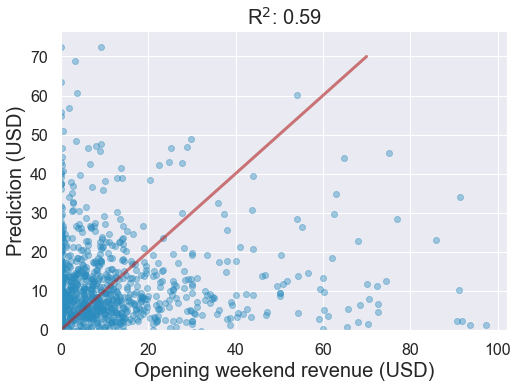

In [843]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_test, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

In [844]:
fig.savefig('../plot/ridge_prediction_test.pdf', bbox_inches='tight', transparent = True)

In [686]:
# fig = get_score(X_train, X_val, y_train, y_val)

(0.0, 102.24400725000001)

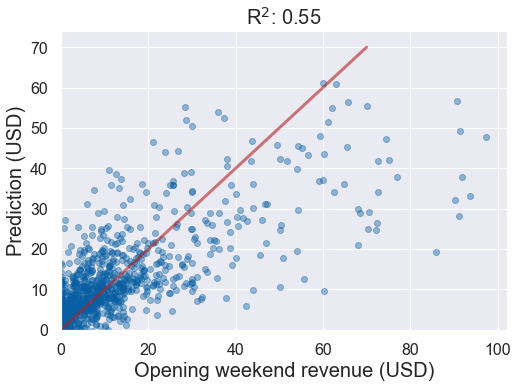

In [685]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

In [687]:
fig.savefig('../plot/ridge_prediction.pdf', bbox_inches='tight', transparent = True)

In [693]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

10.740548723211116

### * LASSO

In [688]:
# lasso_model = Lasso(alpha = 0.001)
# lasso_model.fit(X_train,y_train)
# list(zip(X_train_con_scaled_df.columns, lasso_model.coef_))

In [695]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha


alphavec = 10**np.linspace(-5,5,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)
print('The best value of alpha is:', lasso_model.alpha_)

The best value of alpha is: 0.021544346900318846


In [697]:
lasso_model = Lasso(alpha = 0.0215)
lasso_model.fit(X_train,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('GeorgetownProductionsInc.', 0.0),
 ('Ukrainian', -0.0),
 ('Mandarin', -0.0),
 ('Vietnamese', -0.0),
 ('Arabic', -0.0),
 ('Swahili', -0.0),
 ('BlueSkyStudios', -0.0),
 ('Tagalog', -0.0),
 ('ScottishGaelic', 0.0),
 ('ReelFXCreativeStudios', -0.0),
 ('SaudiArabia', -0.0),
 ('G', 0.0),
 ('BlackBearPictures', -0.0),
 ('IMGlobal', -0.0),
 ('PixarAnimationStudios', 0.0),
 ('ColumbiaPictures', 1.0052196377455793),
 ('LegendaryEntertainment', -0.0),
 ('EndgameEntertainment', -0.0),
 ('Comedy', -0.1841757551183052),
 ('Japan', 1.1022128538387324),
 ('Austria', 0.0),
 ('Unrated', -0.0),
 ('CinergiPicturesEntertainment', -0.0),
 ('Serbian', -0.0),
 ('QuadProductions', -0.0),
 ('Czech', 4.906781827682248),
 ('Norwegian', -2.0123131778570036),
 ('MajorStudioPartners', -0.0),
 ('Romanian', -0.0),
 ('Hawaiian', 0.0),
 ('Romania', 0.0),
 ('Tibetan', -0.0),
 ('FirstLookInternational', 0.0),
 ('TapestryFilms', -0.0),
 ('DreamWorksAnimation', 5.482976944401251),
 ('BrazilianSignLanguage', 0.0),
 ('Hebr

In [708]:
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)),columns=['Feature','Coefficient'])
lassp_top = lasso_coef.sort_values(by=['Coefficient'],ascending=False).head(20)

In [718]:
lassp_top.Feature.tolist()

['budget',
 'Lucasfilm',
 'DreamWorksAnimation',
 'Czech',
 'NewLineCinema',
 'UniversalPictures',
 'ScreenGems',
 'TwentiethCenturyFox',
 'ParamountPictures',
 'Horror',
 'release_year',
 'Animation',
 'Italian',
 'WaltDisneyPictures',
 'runtime',
 'budget release_year',
 'WarnerBros.',
 'Japan',
 'Lionsgate',
 'ColumbiaPictures']

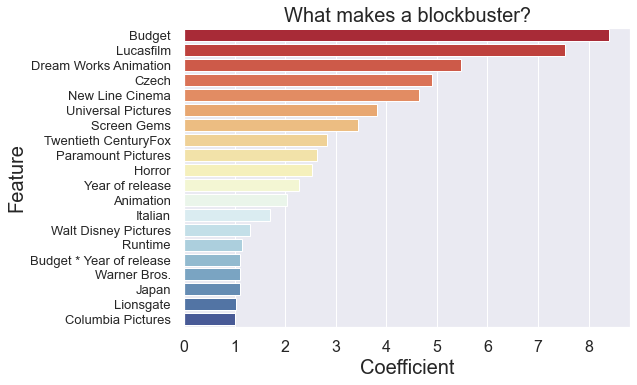

In [733]:

# Generate coef plots for the 3 continuous features
# plt.style.use('seaborn')
import matplotlib.style as style
# style.use('seaborn-poster') #sets the size of the charts
# style.use('seaborn-dark')
# p = sns.color_palette("GnBu_r",20)
p = sns.color_palette("RdYlBu",20)
sns.set_palette(p)

fig, ax = plt.subplots()
sns.set_palette(p)
sns.barplot(y="Feature", x= 'Coefficient', data = lassp_top,orient='h')
ax.set_title('What makes a blockbuster?',fontsize=20)
ax.set_ylabel('Feature',fontsize=20)
ax.set_xlabel('Coefficient',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=13)
# ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_yticklabels(['Budget',
 'Lucasfilm',
 'Dream Works Animation',
 'Czech',
 'New Line Cinema',
 'Universal Pictures',
 'Screen Gems',
 'Twentieth CenturyFox',
 'Paramount Pictures',
 'Horror',
 'Year of release',
 'Animation',
 'Italian',
 'Walt Disney Pictures',
 'Runtime',
 'Budget * Year of release',
 'Warner Bros.',
 'Japan',
 'Lionsgate',
 'Columbia Pictures'])

fig.savefig('../plot/lasso_coef.pdf', bbox_inches='tight', transparent=True)
# fig.savefig('Top_station2.svg', format='svg')

In [699]:
val_pred = lasso_model.predict(X_val)
r2_score(y_val, val_pred)

0.5434235287972282

(0.0, 102.24400725000001)

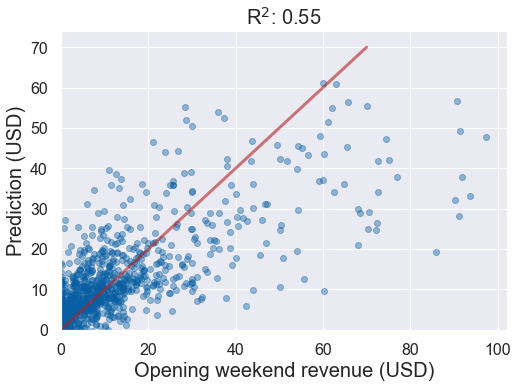

In [700]:
# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

val_score=r2_score(y_val, y_pred)

ax.set_xlabel('Opening weekend revenue (USD)',fontsize=20)
ax.set_ylabel('Prediction (USD)',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#     ax.set_xticks([0,0.2e8,0.4e8,0.6e8,0.8e8])
#     ax.set_xticklabels(['0','20M','40M','60M','80M'])
#     ax.set_yticks([0,0.1e8,0.2e8,0.3e8,0.4e8,0.5e8,0.6e8,0.7e8])
#     ax.set_yticklabels(['0','10M','20M','30M','40M','50M','60M','70M'])

x=np.linspace(0,0.7e2,50)
#     x=np.linspace(4,9,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,)
plt.xlim(0,)

### Test set using movie based on books

In [784]:
# Load the cleaned complete data
test_df = pd.read_pickle('../dump/complete_data_cleaned_test')

In [785]:
test_df.rename(columns = {'actor':'star'},inplace=True)

In [789]:
test_df.dropna(inplace=True)

In [790]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 1 to 1516
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   movie_title             577 non-null    object        
 1   rating                  577 non-null    float64       
 2   MPAA                    577 non-null    object        
 3   genre                   577 non-null    object        
 4   release_date            577 non-null    datetime64[ns]
 5   budget                  577 non-null    float64       
 6   opening_weekend_usa     577 non-null    float64       
 7   gross_usa               577 non-null    float64       
 8   gross_world             577 non-null    float64       
 9   runtime                 577 non-null    float64       
 10  director                577 non-null    object        
 11  writer                  577 non-null    object        
 12  star                    577 non-null    object   

In [787]:
X_test = test_df[con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
y_test = test_df['opening_weekend_usa']

In [782]:
# Get the data from all_df with both continuous and categorical variables
# Get the data from all_df with both continuous and categorical variables
df = all_df[['opening_weekend_usa'] + con_feature + \
            ['genre'] + ['MPAA'] + ['language'] + ['country'] + ['distributor'] + ['star']]
# df = all_df[['gross_usa'] + con_feature + con_book_feature + ['genre']]
X, y = get_Xy(df)

In [791]:
y_pred = ridge_model.predict(X_val)
r2_score(y_test, y_pred)

ValueError: setting an array element with a sequence.